In [1]:
from torch.distributions import MultivariateNormal
import torch
from sampling.samplers import SGLDSampler, MALASampler

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib as mpl

import ipywidgets
from ipywidgets import interact
import IPython
# If in your browser the figures are not nicely vizualized, change the following line.
rcParams['font.size'] = 20
rcParams['figure.figsize'] = (20, 8)

import warnings
warnings.filterwarnings('ignore')
import seaborn as sns 

layout = ipywidgets.Layout(width='auto', height='40px')
%load_ext autoreload
%autoreload 2

In [2]:
from torch.distributions import Normal, Distribution
class RosenbrockDistribution(Distribution):
    r"""Implements Rosenbrock distribution
    Includes unnormalized density and analytic sampler.
    Based on https://arxiv.org/pdf/1903.09556.pdf
    """
    def __init__(self, a=.2, b=1):
        self.a = a
        self.b = b

    def log_prob(self, value):
        log_p = -self.a * value[0] ** 2 - self.b * (value[1] - value[0] ** 2) ** 2
        return log_p

    def rsample(self, sample_shape=torch.Size()):
        if len(sample_shape) > 0:
            num_samples = sample_shape[0]
            squeeze = False
        else:
            num_samples = 1
            squeeze = True

        x = torch.zeros([num_samples, 2])
        x[:, 0] = Normal(0.0, 1 / (2 * self.a) ** 0.5).sample(sample_shape)
        x[:, 1] = Normal(x[:, 0] ** 2, 1 / (2 * self.b) ** 0.5).sample()

        if squeeze:
            x = x.squeeze(0)
        return x
    
def get_distribution(distribution):
    mu = torch.tensor([0.0, 0.0])
    if distribution == "isotropic":
        cov = torch.tensor([[1.0, 0.0], [0.0, 1.0]]) 
        return MultivariateNormal(loc=mu, covariance_matrix=cov) 
    elif distribution == "rotated":
        cov = torch.tensor([[1.3, 0.9], [0.9, 1.3]]) 
        return MultivariateNormal(loc=mu, covariance_matrix=cov)
    elif distribution == "anisotropic":
        cov = torch.tensor([[3.0, 0], [0, 0.1]])
        return MultivariateNormal(loc=mu, covariance_matrix=cov)
    elif distribution == "rosenbrock":
        return RosenbrockDistribution() 
    

## Sampler walk

In [3]:
def sampler_walk(distribution, sampler, preconditioner, lr, noise_free):
    
    x = torch.randn(2)
    x.requires_grad = True 
    dist = get_distribution(distribution)
    if sampler == "mala":
        sampler = MALASampler(
            x, dist.log_prob, preconditioner, noise_free=noise_free, lr=lr, lr_final=lr
        )
    else:
        sampler = SGLDSampler(
            x, dist.log_prob, preconditioner, noise_free=noise_free, lr=lr, lr_final=lr
        )

    samples = []
    alphas = []
    proposal = [0] 
    true_samples = dist.rsample((torch.tensor(500),)).cpu().numpy()
    
    def plot_samples():
        IPython.display.clear_output(wait=True)
        plt.close()
        
        est_samples = np.array(samples)
        plt.plot(est_samples[:, 0], est_samples[:, 1], linestyle="solid", linewidth=0.1, color="r", label="Walk")
        plt.scatter(est_samples[:, 0], est_samples[:, 1], s=10., color="r", label="Generated Samples")
        plt.scatter(est_samples[-1, 0], est_samples[-1, 1], s=100., color="k", label=f"Last Sample")
        plt.scatter(proposal[0][0], proposal[0][1], s=100., color="b",label=f"Proposal  (alpha = {alphas[-1]:.2f})")
        plt.scatter(true_samples[:, 0], true_samples[:, 1], s=10., color="g", label="True Samples")
    
        plt.legend(loc="upper right")
        plt.xlabel(r"$x_1$")
        plt.ylabel(r"$x_2$")
        plt.xlim([-6, 6])
        if distribution == "rosenbrock":
            plt.ylim([-4, 25])
        else:
            plt.ylim([-6, 6])
        
        if len(alphas) > 100:
            acc_prob = np.mean(alphas[:-100])
        else:
            acc_prob = np.mean(alphas)
        plt.title(f"Sampler Walk: Running Avg Acceptance Prob. {acc_prob:.2f}")

        plt.show()

        button = ipywidgets.Button(description="Sample New Point")
        button.on_click(lambda b: query_new_point())
        display(button)
        
        button2 = ipywidgets.Button(description="Sample 100 Points")
        button2.on_click(lambda b: query_new_point(n=100))
        display(button2)
        
        button3 = ipywidgets.Button(description="Sample 1000 Points")
        button3.on_click(lambda b: query_new_point(n=1000))
        display(button3)

    def query_new_point(n=1):
        for _ in range(n):
            sample, loss, alpha, proposal_ = sampler.sample_next()
            samples.append(sample.detach().numpy())
            alphas.append(alpha)
            proposal[-1] = proposal_
        plot_samples()
        

    query_new_point()

interact(
    sampler_walk,
    distribution = ipywidgets.Dropdown(
        value="rosenbrock", options=["isotropic", "rotated", "anisotropic", "rosenbrock"]),
    sampler = ["mala", "sgld"],
    preconditioner=ipywidgets.Dropdown(
        value=True, options=[True, False], style={'description_width': 'initial'}),
    lr = ipywidgets.FloatLogSlider(value=0.3, min=-2, max=1, step=0.01, continuous_update=False),
    noise_free=[False, True]
);


interactive(children=(Dropdown(description='distribution', index=3, options=('isotropic', 'rotated', 'anisotro…

## Demo Guide:

#### some explanation
This demo shows the process how SGLD and MALA sampler converge to the true posterior of some special distribution like isotropic, rotated, "anisotropic, rosenbrock. In the same time you can improve the performance by preconditioning method. 
- distribution: The distribution the sampler want to converge to. We know the likelihood but normally the posterior is intractable.
- Sampler: 
    -SGLD (Stochastic Gradient Langevin Dynamic) method: Can guarantee convergence to the stationary distribution under some learning rate condition.
    -MALA (Metropolis adjusted Langevin Algorithm: Improved proposal considering the gradient information.
- preconditioner: Using adaptive preconditioners [SGLD](https://arxiv.org/pdf/1512.07666.pdf) from optimization to improve efficiency.
- noise_free: Adding Gaussian noise to the gradient import more uncertatiny

#### play around
- See how the sampler converge to different distribution
- Compare the efficiency of SGLD and MALA
- See how the learning rate change the convergence process
- Compare the difference between with noise and noise free

## Logistic Regression

# Generate data

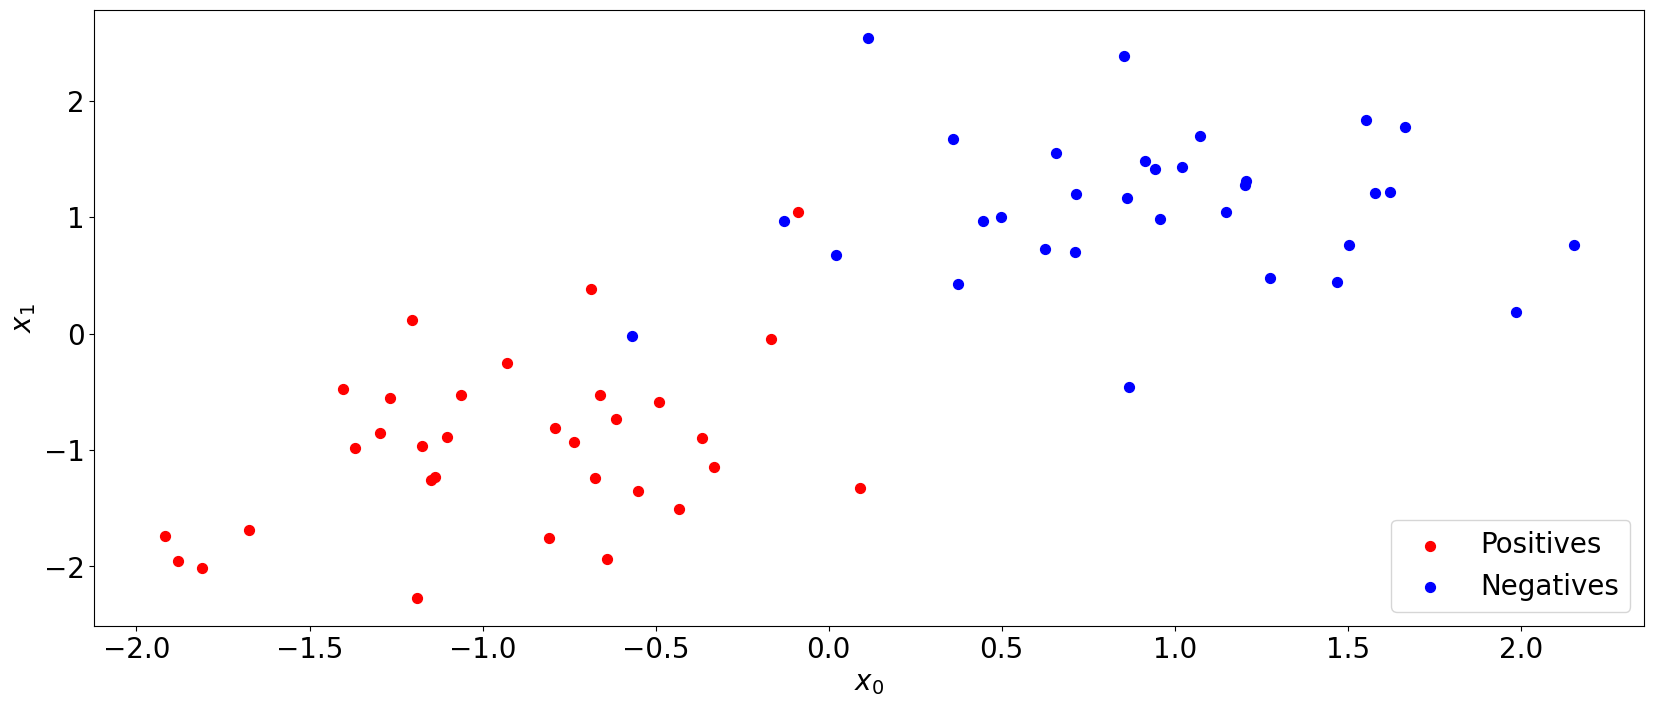

In [4]:
torch.manual_seed(0)
scale = 0.6
X_plus = torch.randn(32, 2) * scale + torch.tensor([-1, -1])
X_minus = torch.randn(32, 2) * scale + torch.tensor([1, 1])
plt.scatter(X_plus[:, 0].detach(), X_plus[:, 1].detach(), s=50., color='r', label="Positives")
plt.scatter(X_minus[:, 0].detach(), X_minus[:, 1].detach(), s=50., color='b', label="Negatives")
plt.xlabel("$x_0$")
plt.ylabel("$x_1$")
plt.legend(loc="lower right")
plt.show()

# Train with different Samplers!

100%|█████████████████████████████████████| 3000/3000 [00:01<00:00, 2684.68it/s]


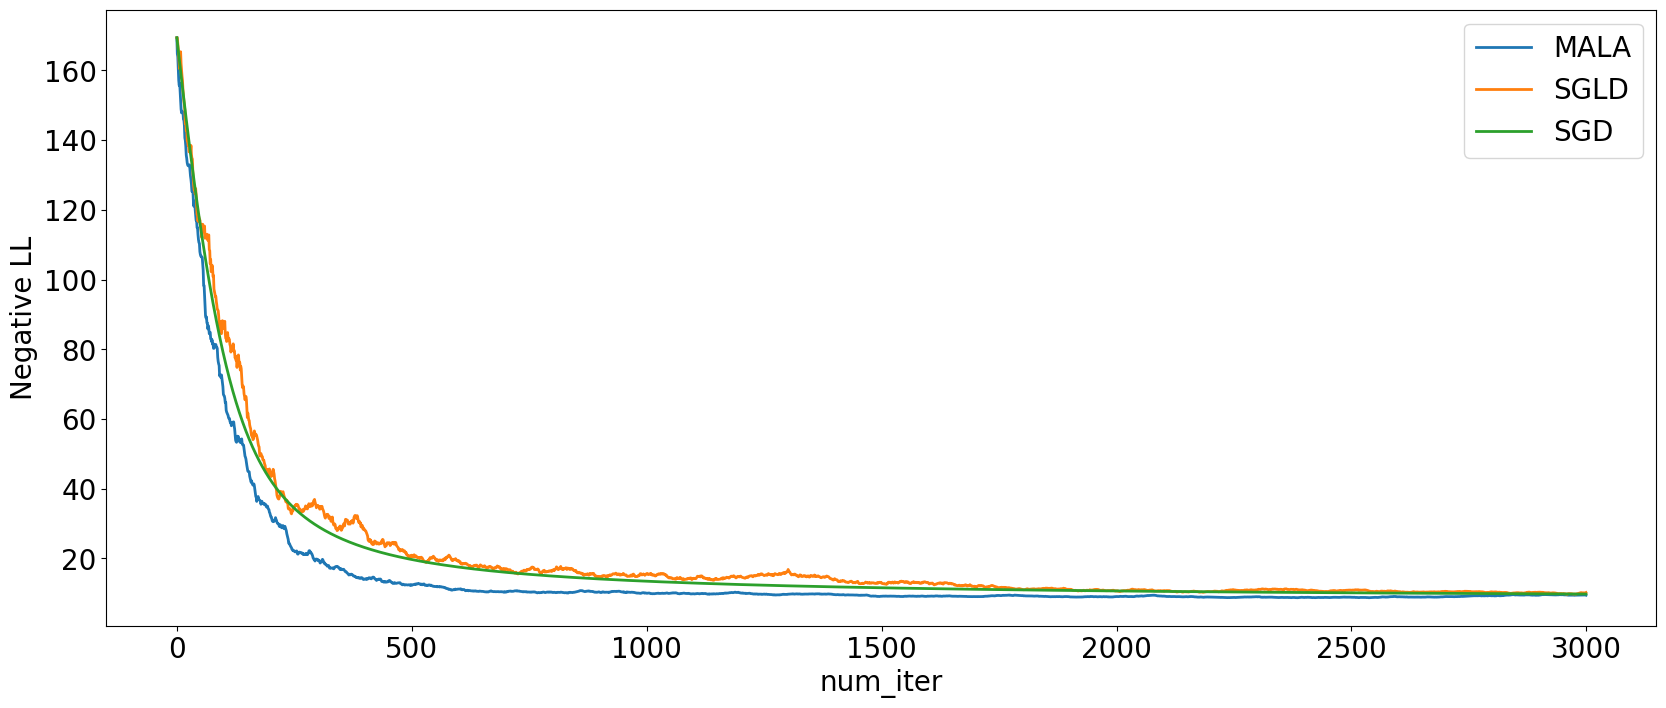

In [5]:
palette = sns.color_palette(n_colors=3)

num_iter = 3000
lr = 1e-2
prior_strength = 0.1

def log_prob(w):
    y_plus = w[2] + X_plus @ w[:2]
    y_minus = w[2] + X_minus @ w[:2]
    pos_loss = torch.log(1 / (1 + torch.exp(y_plus))).sum()
    neg_loss = torch.log(1 / (1 + torch.exp(-y_minus))).sum()
    prior = prior_strength * (w ** 2).sum()
    return pos_loss +neg_loss  + neg_loss

w0 = torch.randn(3)
w_mala = w0.clone()
w_mala.requires_grad = True
mala = MALASampler(
       w_mala, log_prob, False, noise_free=False, lr=lr, lr_final=lr, max_iter=num_iter
    )

w_sgld = w0.clone()
w_sgld.requires_grad = True
sgld = SGLDSampler(
       w_sgld, log_prob, False, noise_free=False, lr=lr, lr_final=lr, max_iter=num_iter
    )
w_sgd = w0.clone()
w_sgd.requires_grad = True
sgd = SGLDSampler(
       w_sgd, log_prob, False, noise_free=True, lr=lr, lr_final=lr, max_iter=num_iter
    )

mala_returns = mala.sample(num_iter, subsampling=1)
sgld_returns = sgld.sample(num_iter, subsampling=1)
sgd_returns = sgd.sample(num_iter, subsampling=1)
mala_samples  = np.array(mala_returns[0])
sgld_samples = np.array(sgld_returns[0])
sgd_samples = np.array(sgd_returns[0])

plt.plot(mala_returns[1], label="MALA", color=palette[0], linewidth=2)
plt.plot(sgld_returns[1], label="SGLD", color=palette[1], linewidth=2)
plt.plot(sgd_returns[1], label="SGD", color=palette[2], linewidth=2)

plt.xlabel("num_iter")
plt.ylabel("Negative LL")
plt.legend(loc="best")
plt.show()


#### some explanation
This graph shows the negative log-likelihood change with different sampler method


# See posterior distribution over the last (N) samples

In [6]:
x = np.linspace(-2, 2); 

def decision_boundary(x, w):
    w = w.detach().numpy()
    y = -w[2] / w[1] - w[0] / w[1] * x
    return y

def get_bounds(x, w):
    c = -w[:, 2] / w[:, 1]
    m = -w[:, 0] / w[:, 1] 
    y = c[:, np.newaxis] + np.outer(m, x) 
    
    mean = np.mean(y, 0)
    std = np.std(y, 0)
    
    return mean, mean - std, mean + std 


def number_of_samples(num):
    fig, axes = plt.subplots(ncols=3, nrows=1)
    for i in range(3):
        axes[i].hist(mala_samples[-num:, i], color=palette[0], alpha=0.5, bins=10, label="MALA", density=True)
        axes[i].hist(sgld_samples[-num:, i], color=palette[1], alpha=0.5, bins=10, label="SGLD", density=True)
        axes[i].hist(sgd_samples[-num:, i], color=palette[2], alpha=0.5, bins=10, label="SGD", density=True)

        axes[i].set_title(f"$w_{i}$")
    axes[0].legend(loc="best")
    
    plt.show()

    mala_mean, mala_low, mala_high = get_bounds(x, mala_samples[-num:])
    sgld_mean, sgld_low, sgld_high = get_bounds(x, sgld_samples[-num:])
    sgd_mean, sgd_low, sgd_high = get_bounds(x, sgd_samples[-num:])

    plt.plot(x, mala_mean, color=palette[0], label="MALA", linewidth=5)
    plt.fill_between(x, mala_low, mala_high, color=palette[0], alpha=0.3)

    plt.plot(x, sgld_mean, color=palette[1], label="SGLD", linewidth=5)
    plt.fill_between(x, sgld_low, sgld_high, color=palette[1], alpha=0.3)

    plt.plot(x, sgd_mean, color=palette[2], label="SGD", linewidth=5)
    plt.fill_between(x, sgd_low, sgd_high, color=palette[2], alpha=0.3)

    plt.scatter(X_plus[:, 0].detach(), X_plus[:, 1].detach(), s=20., color='r', label="Positives")
    plt.scatter(X_minus[:, 0].detach(), X_minus[:, 1].detach(), s=20., color='b', label="Negatives")
    plt.legend(loc="best");
    plt.xlabel("$x_0$")
    plt.ylabel("$x_1$")
    plt.xlim([-2, 2])
    plt.ylim([-2, 2])
    plt.title("Decision Boundary");
    plt.show()
    
    
interact(number_of_samples, num=ipywidgets.IntSlider(value=500, min=50, max=num_iter, step=50, continuous_update=False));

interactive(children=(IntSlider(value=500, continuous_update=False, description='num', max=3000, min=50, step=…

## Demo Guide:

#### some explanation
These above graphies shows the weight posterior distribution in the last N samples
- num: Last N samples. In this histogram we will consider more sampled weights. In the decision boundary graph we take the average of above weights 


In [7]:
def plot_classification_boundaries(w, fig=None, n_points=100):
    min_x = -3
    max_x = 3
    min_y = -3
    max_y = 3
    [xg, yg] = np.meshgrid(np.linspace(min_x, max_x, n_points),
                           np.linspace(min_y, max_y, n_points))

    x1g = np.concatenate((xg.reshape([-1, 1]),
                          yg.reshape([-1, 1]),
                          np.ones_like(xg).reshape([-1, 1])),
                         axis=1)

    Zg = 1 / (1 + np.exp(x1g @ w))
    zg = np.reshape(Zg, newshape=xg.shape)
    cmap = mpl.cm.jet
    norm = mpl.colors.Normalize(vmin=0, vmax=1)

    contour = plt.contourf(xg, yg, zg, cmap=cmap, alpha=0.3, vmin=0, vmax=1, levels=5)
    cb = plt.colorbar(contour)
    plt.scatter(X_plus[:, 0].detach(), X_plus[:, 1].detach(), s=20., color='r', label="Positives")
    plt.scatter(X_minus[:, 0].detach(), X_minus[:, 1].detach(), s=20., color='b', label="Negatives")
    plt.xlabel("$x_0$")
    plt.ylabel("$x_1$")
    plt.xlim(-2, 2)
    plt.ylim(-2, 2)

#     cb1 = mpl.colorbar.ColorbarBase(plt.gca(), cmap=cmap, norm=norm)

    plt.title("Positive Probability")
    
def progress(sampler):
    if sampler == "mala":
        samples = mala_samples
    if sampler == "sgld":
        samples = sgld_samples
    if sampler == "sgd":
        samples = sgd_samples
    k = num_iter // 50
    for sample in samples[::k]:
        try:
            IPython.display.clear_output(wait=True)
            plt.close()
            plot_classification_boundaries(sample)
            plt.show()
        except KeyboardInterrupt:
            return
interact(progress, sampler=["mala", "sgld", "sgd"]);

interactive(children=(Dropdown(description='sampler', options=('mala', 'sgld', 'sgd'), value='mala'), Output()…

## Demo Guide:

#### some explanation
These above graph vividly shows the change of the decision boundary in logistic regression.

#### play around
- Compare the boundary changes between different method
